# Tentativa de análise estatística inferencial de dados econômicos do Brasil

### Info:
- https://www.ibge.gov.br/explica/inflacao.php 

### Dados analizados:
- https://sidra.ibge.gov.br/tabela/1737
- https://dados.gov.br/dataset/dolar-americano-usd-todos-os-boletins-diarios
- https://www.eia.gov/dnav/pet/hist/rbrteM.htm
- https://stats.oecd.org/Index.aspx?DataSetCode=PRICES_CPI#

In [1]:
# importação das bibliotecas principais
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

path = 'dados'
filename = {
    'ipca mensal':'IPCA - Variação mensal', 
    'ipca acumulado':'IPCA - Variação acumulada em 12 meses', 
    'dolar':'Cotação do Dólar', 
    'oil':'RBRTEm',
    'cpi':'PRICES_CPI'
}

Para facilitar a análise será implementado algumas funções, sendo elas:
- Coeficiente de correlação linear:
\\[corrccoef\_linear(x, y) = \dfrac{n\sum{xy} - (\sum{x})(\sum{y})}{\sqrt{n\sum{x^2} - (\sum{x})^2}\sqrt{n\sum{y^2} - (\sum{y})^2}} \\]
- Método dos mínimos quadrados (MMQ):
\\[Y = mX + b\\]
\\[m = \dfrac{\sum{(x - \bar{x})(y - \bar{y})}}{\sum{(x - \bar{x})^2}}\\]
\\[b = \bar{Y} - m\bar{X}\\]

In [2]:
def nrange(xi, xf=None, dx=1):
    '''
    Contagem com intervalo aberto.
    
    Args:
        xi: float; Valor inicial.
        xf: float; Valor final.
        dx: foat; Intervalo.
    '''
    if not xf: xf = xi; xi = 0
    while xi <= xf:
        yield xi
        xi += dx
    
def get(var_list, indexes, array=False):
    var = []
    for i in indexes:
        try: u = var_list[i]
        except IndexError: u = np.nan
        var.append(u)
    return np.array(var) if array else var

def corrcoef_linear(X, Y):
    n = len(X)
    return (n*np.nansum(X*Y) - np.nansum(X)*np.nansum(Y))/((n*np.nansum(X**2) - np.nansum(X)**2)**0.5 * (n*np.nansum(Y**2) - np.nansum(Y)**2)**0.5)

def MMQ(X, Y, angular=False):
    m = np.nansum((X - np.nanmean(X))*(Y - np.nanmean(Y)))/np.nansum((X - np.nanmean(X))**2)
    b = np.nanmean(Y) - m*np.nanmean(X)
    f = lambda x: m*x + b
    return [f, m] if angular else f

def rmap(h, hmin, hmax, ymin, ymax):
    return (ymax-ymin)/((hmax-hmin) if (hmax-hmin) else 1)*(h - hmin) + ymin

def moving_average(x, w):
    wi = int(w/2)
    wf = wi+1
    u = []
    for i in range(len(x)):
        values = x[i-wi:i+wf]
        if len(values):
            if len(values) < w: w = len(values)
            u.append(np.sum(values)/w)
        else: u.append(0)
    return u

## 1.0 Importação dos dados

#### Para facilitar a análise os dados serão armazenados no formato de vetor (numpy array).
 - A variável `month` armazena as datas para ter referência.

 ### 1.1 Importação dos dados do IPCA

In [3]:
ipca_mensal = pd.read_csv(os.path.join(path, filename['ipca mensal'])+'.csv').to_numpy().T[1]
month, ipca_acum = pd.read_csv(os.path.join(path, filename['ipca acumulado'])+'.csv').to_numpy().T
month = list(month)
pd.read_csv(os.path.join(path, filename['ipca acumulado'])+'.csv')

,mês,valor
0,01-1980,NaN
1,02-1980,NaN
2,03-1980,NaN
3,04-1980,NaN
4,05-1980,NaN
...,...,...
494,03-2021,6.10
495,04-2021,6.76
496,05-2021,8.06
497,06-2021,8.35


### 1.2 Importação dos dados sobre o dólar

In [4]:
df1 = pd.read_csv(os.path.join(path, filename['dolar'])+'.csv')
df1

,compra,venda,data
0,2814.0000,2828.0000,03-12-1984
1,2814.0000,2828.0000,03-12-1984
2,2867.0000,2881.0000,04-12-1984
3,2867.0000,2881.0000,05-12-1984
4,2867.0000,2881.0000,05-12-1984
...,...,...,...
9036,5.1620,5.1626,04-01-2021
9037,5.3263,5.3269,05-01-2021
9038,5.3176,5.3182,06-01-2021
9039,5.3427,5.3433,07-01-2021


- **Analisando os dos valores da cotação, temos:**

Média: -1.1480041256498195
Média da diferença absoluta: 1.1496247428381834
Mediana: -0.0007999999999999119
Variância: 41.21736763009359
Desvio padrão: 6.420075360156888


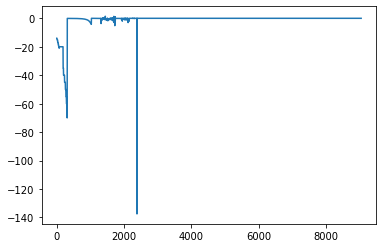

In [5]:
difcot = df1['compra'] - df1['venda'] # diferença entre a cotação de compra e cotação de venda
print('Média:', np.mean(difcot))
print('Média da diferença absoluta:', np.mean(abs(difcot)))
print('Mediana:', np.median(difcot))
print('Variância:', np.var(difcot))
print('Desvio padrão:', np.std(difcot))
plt.plot(difcot)
plt.show()

Pode-se observar que os valores, no geral, tem pouca variação. Logo, para a análise, será tomado a média dos valores em torno da data. Para relacionar os dados será tomado a média mensal da cotação.

In [6]:
%%time
f_mstf = lambda x: '-'.join(x.split('-')[1:])
month_cot = [f_mstf(m) for m in df1['data']]
cot_dolar = []
for M in month:
    val = []
    for i, m in enumerate(month_cot):
        if m == M: val.append((df1.iloc[i]['compra'] + df1.iloc[i]['venda'])/2)
    cot_dolar.append(np.nan if not len(val) else np.mean(val))
cot_dolar = np.array(cot_dolar)

Wall time: 12.6 s


### 1.3 Importação dos dados sobre o preço do barril de petróleo

In [7]:
df2 = pd.read_csv(os.path.join(path, filename['oil'])+'.csv')
oil_price = []
for M in month:
    value = df2.loc[df2['date'] == M]
    oil_price.append(value.iloc[0]['brent spot price'] if len(value) else np.nan)
oil_price = np.array(oil_price)
df2.head()

,date,brent spot price
0,05-1987,18.58
1,06-1987,18.86
2,07-1987,19.86
3,08-1987,18.98
4,09-1987,18.31


In [8]:
prices_cpi = pd.read_csv(os.path.join(path, filename['cpi'])+'.csv').drop(columns='Date')
prices_cpi.head()

,Luxembourg,OECD - Europe,Brazil,G20,Slovak Republic,Turkey,Canada,Latvia,Slovenia,Germany,...,Italy,Ireland,Lithuania,South Africa,France,Switzerland,China (People's Republic of),Israel,Sweden,Japan
0,3.214605,5.878082,8.853113,4.459063,13.61772,68.87825,2.185792,3.089545,7.781360,1.549464,...,2.203857,4.017217,0.852384,2.648305,1.539053,1.585403,-0.2,1.216216,0.448046,-0.9
1,2.669265,5.993550,7.862087,4.633076,16.42276,69.74646,2.729258,3.468712,8.422837,1.547619,...,2.383135,4.279601,0.814968,2.330508,1.355325,1.623698,0.7,1.632653,0.931229,-0.6
2,2.812105,5.917166,6.923308,4.676515,16.54501,67.89619,3.043478,3.242113,9.034197,1.547619,...,2.470265,4.694168,0.828476,3.389831,1.491016,1.482930,-0.2,1.500682,1.032529,-0.5
3,2.711602,5.545000,6.774717,4.280593,15.98063,63.82483,2.162162,3.752836,9.242109,1.066351,...,2.281022,4.809052,0.783294,4.545455,1.207269,1.402478,-0.3,1.768708,0.720400,-0.8
4,2.549493,5.572327,6.465620,4.277447,16.02254,62.67466,2.373247,3.076121,9.037951,0.947867,...,2.459016,5.211267,0.451928,5.079365,1.397713,1.580529,0.1,1.894452,1.008969,-0.7


### 1.4 Plotagem dos dados 

In [10]:
def month_range(month_i=None, month_f=None, step=1, label_map=lambda a:a):
    '''
    Pegar índices a partir da data.
    
    Args:
        month_i: string; data inicial.
        month_f: string; data final.
        step: int; período de diferença entre os meses.
    
    Return: list[ list[x], list[xt] ], onde 'x' são os índices e 'xt' as respectivas datas.
    '''
    if not month_i: month_f = month[-1]; month_i = month[0]
    elif not month_f: month_f = month_i; month_f = month[-1]
    x, xt = [], []
    for t in nrange(month.index(month_i), month.index(month_f), step):
        x.append(t)
        xt.append(label_map(month[t]))
    return x, xt

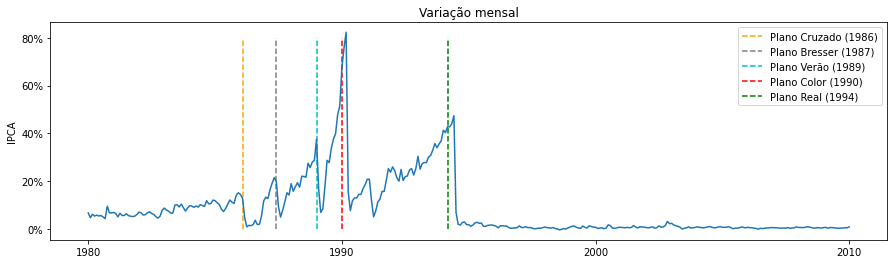

In [66]:
month_num_remove = lambda a: a.split('-')[-1]
percent = lambda a: f'{a}%'
t, tlabel = month_range('01-1980', '01-2010')

plt.figure(figsize=(15, 4))
plt.title('Variação mensal')
plt.vlines(month.index('02-1986'), 0, 80, color='orange', linestyles='dashed', label='Plano Cruzado (1986)')
plt.vlines(month.index('06-1987'), 0, 80, color='gray', linestyles='dashed', label='Plano Bresser (1987)')
plt.vlines(month.index('01-1989'), 0, 80, color='c', linestyles='dashed', label='Plano Verão (1989)')
plt.vlines(month.index('01-1990'), 0, 80, color='r', linestyles='dashed', label='Plano Color (1990)')
plt.vlines(month.index('03-1994'), 0, 80, color='g', linestyles='dashed', label='Plano Real (1994)')
plt.plot(t, get(ipca_mensal, t))
plt.xticks(*month_range('01-1980', '01-2010', step=120, label_map=month_num_remove))
y_values = np.arange(0, 81, 20)
plt.yticks(y_values, map(percent, y_values))
plt.ylabel('IPCA')
plt.legend()
plt.show()

No gráfico acima tem-se uma visão geral da inflação no Brasil e a chamada [Hiperinflação](https://pt.wikipedia.org/wiki/Hiperinfla%C3%A7%C3%A3o_no_Brasil)

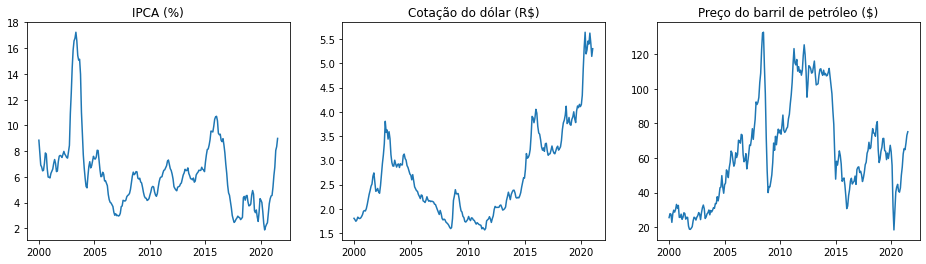

In [65]:
fis, axs = plt.subplots(1, 3, figsize=(16, 4))
x, xt = month_range('01-2000', step=12*5, label_map=remove_month)

axs[0].plot(range(x[0], len(month)), ipca_acum[x[0]:])
axs[0].title.set_text('IPCA (%)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(xt)

axs[1].plot(range(x[0], len(month)), cot_dolar[x[0]:])
axs[1].title.set_text('Cotação do dólar (R$)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(xt)

axs[2].plot(range(x[0], len(month)), oil_price[x[0]:])
axs[2].title.set_text('Preço do barril de petróleo ($)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(xt)

plt.show()

48


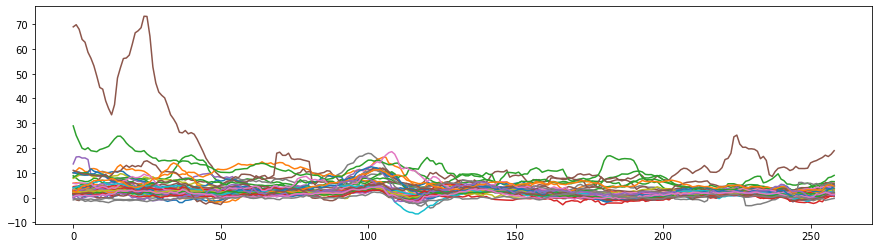

In [12]:
plt.figure(figsize=(15,4))
print(len(prices_cpi.columns.values))
for country in prices_cpi.columns.values:
    plt.plot(prices_cpi[country])
plt.show()

## 2.0 Análise geral

### 2.1 Correlação entre variáveis

Para tentar elaborar modelos para a inflação é preciso encontrar variáveis que estejam relacionados com a variação dos preços no Brasil. A variáveis analisadas são:
- Passagem do tempo;
- Cotação do dólar;
- Preço do barril de petróleo.

Se for verificado alguma relação entre tais variáveis será possivel explicá-la matematicamente.

O gráfico abaixo mostra o valor *relativo* de cada variável.

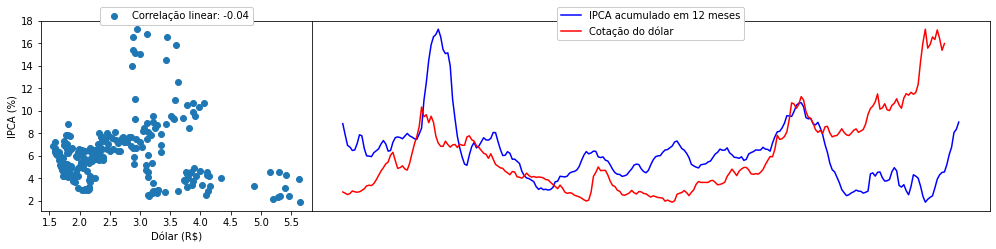

In [194]:
fig = plt.figure(figsize=(17, 3.5))
grid = fig.add_gridspec(1, 7)
axs = [
    fig.add_subplot(grid[0, :2]),
    fig.add_subplot(grid[0, 2:]),
]

x = month_range('01-2000', step=12*3)[0]
ri = range(x[0], len(month))

dados = [
    ['IPCA acumulado em 12 meses', ipca_acum[x[0]:], 'b'],
    ['Cotação do dólar', cot_dolar[x[0]:], 'r']
]

t = month_range('01-2000', step=12*2)[0]
x, y = cot_dolar[t[0]:], ipca_acum[t[0]:]
axs[0].scatter(x, y, label=f'Correlação linear: {corrcoef_linear(x, y):.2f}')
axs[0].set_ylabel('IPCA (%)')
axs[0].set_xlabel('Dólar (R$)')

for label, data, color in dados[:2]:
    data = rmap(data, np.nanmin(data), np.nanmax(data), 0, 1)
    axs[1].plot(ri, data, label=label, c=color)
axs[1].set_yticks([])
axs[1].set_yticks([], minor=True)
axs[1].set_xticks([])
axs[1].set_xticks([], minor=True)

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), framealpha=1)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), framealpha=1)
plt.subplots_adjust(wspace=0)
plt.show()

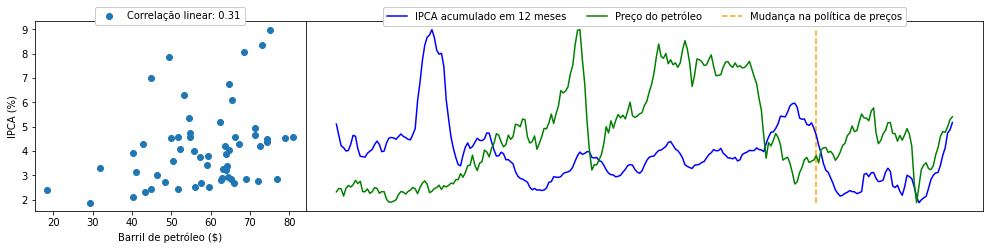

In [200]:
fig = plt.figure(figsize=(17, 3.5))
grid = fig.add_gridspec(1, 7)
axs = [
    fig.add_subplot(grid[0, :2]),
    fig.add_subplot(grid[0, 2:]),
]

x = month_range('01-2000', step=12*3)[0]
ri = range(x[0], len(month))

dados = [
    ['IPCA acumulado em 12 meses', ipca_acum[x[0]:], 'b'],
    ['Preço do petróleo', oil_price[x[0]:], 'g']
]

t = month_range('10-2016', step=12*2)[0]
x, y = oil_price[t[0]:], ipca_acum[t[0]:]
axs[0].scatter(x, y, label=f'Correlação linear: {corrcoef_linear(x, y):.2f}')
axs[0].set_ylabel('IPCA (%)')
axs[0].set_xlabel('Barril de petróleo ($)')

for label, data, color in dados[:2]:
    data = rmap(data, np.nanmin(data), np.nanmax(data), 0, 1)
    axs[1].plot(ri, data, label=label, c=color)
axs[1].set_yticks([])
axs[1].set_yticks([], minor=True)
axs[1].set_xticks([])
axs[1].set_xticks([], minor=True)

axs[1].vlines(month.index('10-2016'), 0, 1, color='orange', linestyles='dashed', label='Mudança na política de preços')

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), framealpha=1)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), framealpha=1, ncol=3)
plt.subplots_adjust(wspace=0)
plt.show()

Sobre o gráfico podemos resaltar alguns pontos:
- A partir de outubro de 2016 a política de preços da Pretrobras foi alterada e passou a ser ditada pelo preço do barril de petróleo no mercado internacional. Por isso, pode-se observar que a variação dos preços está fortimente ao barril do petróleo.

Agora podemos observar o digrama de disperção para cada variável:

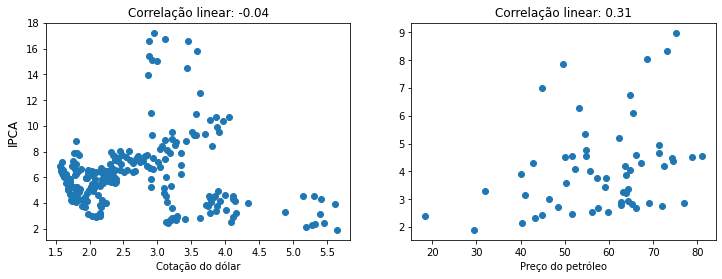

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

t = month_range('01-2000', step=12*2)[0]
x, y = cot_dolar[t[0]:], ipca_acum[t[0]:]
axs[0].title.set_text(f'Correlação linear: {corrcoef_linear(x, y):.2f}')
axs[0].scatter(x, y)
axs[0].set_xlabel('Cotação do dólar')

t = month_range('10-2016', step=12*2)[0]
x, y = oil_price[t[0]:], ipca_acum[t[0]:]
axs[1].title.set_text(f'Correlação linear: {corrcoef_linear(x, y):.2f}')
axs[1].scatter(x, y)
axs[1].set_xlabel('Preço do petróleo')

fig.supylabel('IPCA', x=0.08)
plt.show()

## 3.0 Regressão

*Observação: quanto aos preços do petróleo, foram plotados os dados a partir de outubro de 2016, que foi quando o valor do petróleo no mercado internacional começou a influemciar os preços dos produtos no Brasil através da petrobras.*

Como podemos perceber, a correlação linear para as variáveis é bem fraca. Uma explicação para isso seria que os dados plotados correspondem aos valores a partir de janeiro de 2000, o que não cabe no problema já que o foco é encontrar uma relação para a **inflação**. Portanto, podemos encontrar períodos que caracterizam uma inflação. Para isso, o algoritmo a seguir irá varificar períodos em que os valores so IPCA são crescentes ao longo de 6 meses e tem variação maior ou igual à 4%, para reduzir o ruído será tomado a média móvel em 12 meses.

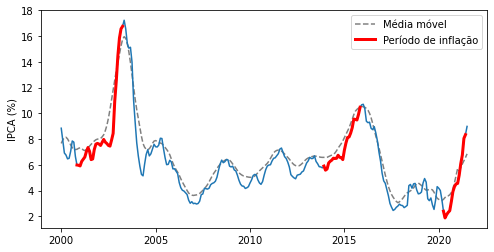

In [203]:
t = month_range('01-2000')[0]
av_ipca = moving_average(ipca_acum, 12)

infl = []
infl_add = []
for i in range(t[0], len(av_ipca)):
    if av_ipca[i-1] <= av_ipca[i]: infl_add.append(i)
    elif len(infl_add):
        infl.append(infl_add.copy())
        infl_add.clear()
infl.append(infl_add.copy())

cont = True
while cont:
    cont = False
    for i in range(len(infl)-1):
        if infl[i+1][0] - infl[i][-1] < 6: 
            infl[i] += infl[i+1]
            infl.pop(i+1)
            cont = True
            break

infl_br = [np.arange(val[0], val[-1]) for val in infl if len(val) > 6 and np.max(ipca_acum[val[0]:val[-1]]) - np.min(ipca_acum[val[0]:val[-1]]) > 4]

plt.figure(figsize=(8,4))
plt.ylabel('IPCA (%)')
plt.plot(t, av_ipca[t[0]:], '--', c='gray', label='Média móvel')
plt.plot(t, ipca_acum[t[0]:])
lines = [plt.plot(var, get(ipca_acum, var), '-', c='r', linewidth=3)[0] for var in infl_br]
lines[0].set_label('Período de inflação')
plt.xticks(*month_range('01-2000', step=60, label_map=remove_month))
plt.legend()
plt.show()

Agora, já com os períodos inflacionários, podemos comparar as variáveis durante tais períodos. Começando pela cotação do dólar:

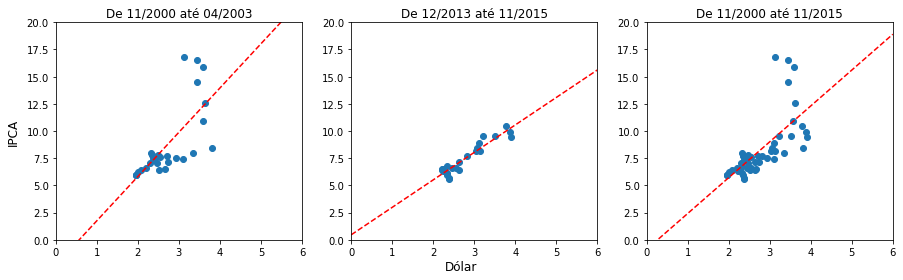

,Período,Correlção linear,Coeficiente angular
0,De 11/2000 até 04/2003,71.74%,4.070301
1,De 12/2013 até 11/2015,94.47%,2.527186
2,De 11/2000 até 11/2015,69.94%,3.297854


In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

rs = []
rows = []
ang_coefs = []
models = []
for i, Y in enumerate(list(infl_br[:-1]) + [list(infl_br[0]) + list(infl_br[1])]):
    title = f'De {month[Y[0]]} até {month[Y[-1]]}'.replace('-', '/')
    X = np.array(get(cot_dolar, Y))
    Y = np.array(get(ipca_acum, Y))
    
    f, m = MMQ(X, Y, angular=True)
    models.append(f)
    ang_coefs.append(m)
    rs.append(f'{corrcoef_linear(X, Y)*100:.2f}%')
    rows.append(title)
    
    axs[i].set_xlim(0, 6)
    axs[i].set_ylim(0, 20)
    axs[i].title.set_text(title)
    axs[i].scatter(X, Y)
    X = np.linspace(0, 6, 100)
    axs[i].plot(X, f(X), '--', c='r')
    
fig.supxlabel('Dólar')
fig.supylabel('IPCA', x=0.08)
plt.show()
pd.DataFrame({'Período':rows, 'Correlção linear':rs, 'Coeficiente angular':ang_coefs}).head()

Quanto ao valor do petróleo só poderão ser análisados os valores do período inflacionário de 2020. Portanto, foi encontrado o valor de 89% de correlação linear. Abaixo mostra o gráfico de disperção já com o modelo de regressão linear (MMQ).

Correlação linear: 89.00%


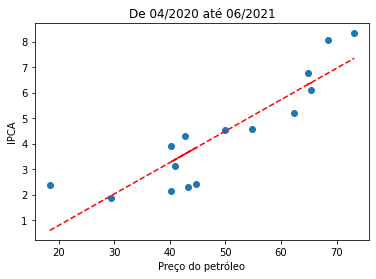

In [17]:
Y = infl_br[-1]
plt.title(f'De {month[Y[0]]} até {month[Y[-1]]}'.replace('-', '/'))
X = np.array(get(oil_price, Y))
Y = np.array(get(ipca_acum, Y))
print(f'Correlação linear: {corrcoef_linear(np.array(X), np.array(Y))*100:.2f}%')

f = MMQ(X, Y)

plt.scatter(X, Y)
plt.plot(X, f(X), '--', c='r')
plt.xlabel('Preço do petróleo')
plt.ylabel('IPCA')
plt.show()

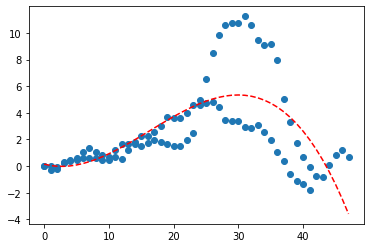

In [18]:
T = []
U = []
for i in range(len(infl_br)-1):
    xdas = np.concatenate([infl_br[i], range(infl_br[i][-1], infl_br[i][-1]+18)])
    T.append(np.arange(len(xdas)))
    y = get(ipca_acum, xdas, True)
    U.append(y-y[0])

X = np.concatenate(T)
Y = np.concatenate(U)

modeloPoly = np.poly1d(np.polyfit(X, Y, 3))

plt.scatter(X, Y)
plt.plot(modeloPoly(T[0]), '--', c='r')
plt.show()

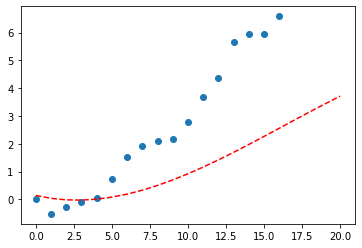

In [19]:
xdas =  np.concatenate([infl_br[-1], range(infl_br[-1][-1], infl_br[-1][-1]+6)])
X = np.arange(len(xdas))
Y = get(ipca_acum, xdas, True)

plt.scatter(X, Y-Y[0])
plt.plot(modeloPoly(X), '--', c='r')
plt.show()

Para melhorar a modelagem do modelo será coletado dados do índice de preços ao consumidor de vários países.

In [20]:
%%time
t = np.arange(len(month_range('01-2000')[0]))

infl_period = []
for country in prices_cpi.columns.values:
    if country != 'Brazil': data_o = prices_cpi[country].values[:-1]
    else: data_o = prices_cpi[country].values
    data = moving_average(data_o, 12)

    infl = []
    infl_add = []
    for i in range(t[0], len(data)-1):
        if data[i] <= data[i+1]: infl_add.append(i)
        elif len(infl_add):
            infl.append(infl_add.copy())
            infl_add = []
    if len(infl_add): infl.append(infl_add.copy())

    cont = True
    while cont:
        cont = False
        for i in range(len(infl)-1):
            if infl[i+1][0] - infl[i][-1] <= 3: # verificar se o tempo entre os períodos de inflação é pequeno.
                infl[i] += infl[i+1]
                infl.pop(i+1)
                cont = True
                break

    for val in infl:
        if 18 > len(val) > 6:
            dy = data_o[val[-1]] - data_o[val[0]]
            if 15 >= dy >= 5:
                u = 0 if val[-1] + 4 >= len(data_o) else 4
                xdas = np.arange(val[0], val[-1]+u)
                infl_period.append(get(data_o, xdas, True))

len_max = max(map(len, infl_period))
infl_period_0 = np.array([np.concatenate([var, [np.nan]*(len_max - len(var))]) for var in infl_period])
infl_period = np.array([var - var[0] for var in infl_period_0])
infl_period_mensal = np.array([[var[i+1] - var[i] for i in range(len(var)-1)] for var in infl_period_0])
print(infl_period.shape)

(10, 20)
Wall time: 495 ms


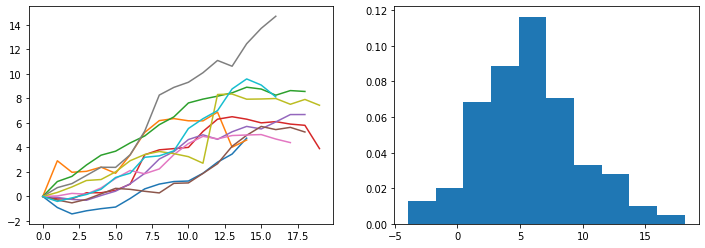

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for values in infl_period: axs[0].plot(np.arange(len_max), values)
axs[1].hist(np.concatenate(infl_period_0), density=True)
plt.show()

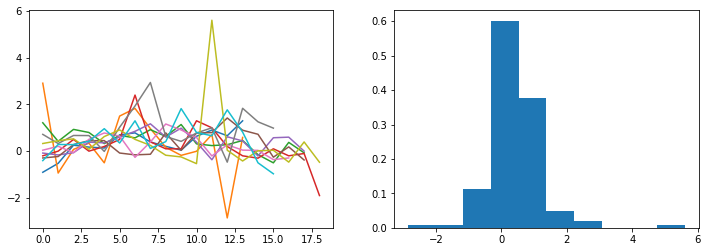

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for values in infl_period_mensal: axs[0].plot(np.arange(len_max-1), values)
axs[1].hist(np.concatenate(infl_period_mensal), density=True)
plt.show()

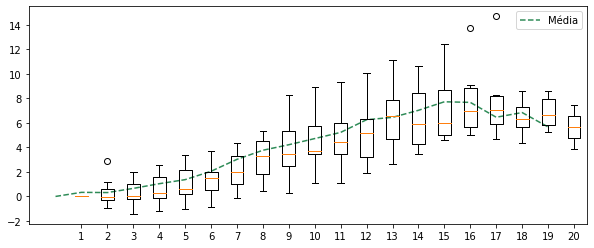

In [23]:
plt.figure(figsize=(10,4))
plt.plot([np.nanmean(a) for a in infl_period.T], '--', label='Média', c='seagreen')
plt.boxplot([a[~np.isnan(a)] for a in infl_period.T])
plt.legend()
plt.show()

6.290906983753747


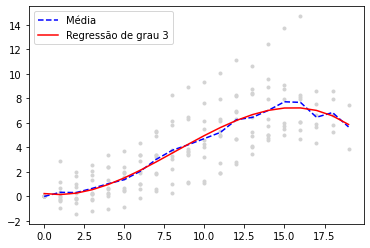

In [24]:
X = np.arange(len_max)
train_vars = np.array([[x, np.nanmean(a)] for x, a in enumerate(infl_period.T)]).T
total_poly_model = np.poly1d(np.polyfit(*train_vars, 3))
Y = total_poly_model(X)
total_sum = 0
for values in infl_period: 
    plt.plot(X, values, '.', c='lightgray')
    values = values[~np.isnan(values)]
    total_sum += mean_squared_error(values, Y[:len(values)])

print(np.sqrt(total_sum))

plt.plot([np.nanmean(a) for a in infl_period.T], '--', label='Média', c='blue')
plt.plot(Y, c='r', label='Regressão de grau 3')
plt.legend()
plt.show()

1.8277367724010263


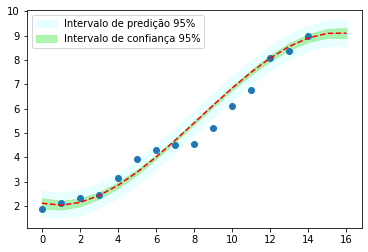

In [25]:
#xdas =  np.concatenate([infl_br[-1], range(infl_br[-1][-1], infl_br[-1][-1]+6)])
values = infl_br[-1]
xdas = np.arange(values[0]+1, values[-1]+4)
X = np.arange(len(xdas))
Y = get(ipca_acum, xdas, True)
y0 = total_poly_model(X) + Y[0] # o modelo avalia o crescimento, portanto para cada valor deve-se acrescentar o fator inicial

n = len(x)
dof = n - 2
t = stats.t.ppf(0.975, dof)
std_error = np.sqrt(np.nansum((Y - y0)**2)/dof)
print(np.sqrt(np.nansum((Y - y0)**2)))
x_mean = np.nanmean(X)
ci = t * std_error * (1/n + (X - x_mean)**2 / np.sum((X - x_mean)**2))**0.5
pi = t * std_error * (1 + 1/n + (X - x_mean)**2 / np.sum((X - x_mean)**2))**0.5 

plt.fill_between(X, y0 + pi, y0 - pi, color = 'lightcyan', label = 'Intervalo de predição 95%', alpha=0.7)
plt.fill_between(X, y0 + ci, y0 - ci, color = 'lightgreen', label = 'Intervalo de confiança 95%', alpha=0.7)
plt.scatter(X, Y)
plt.plot(y0, 'r--')
plt.legend()
plt.show()

O objetivo é avaliar a evolução dos preços ao decorrer do tempo, então para criar o modelo polinomial os valores foram modificados de tal forma que o ponto que marca o início do período inflacionário tenha valor 0, assim o modelo segue a curvatura sem levar em conta o estado inicial dos dados. Em termos de algoritmo, para cada vetor que armazena um determinado período inflacionário foi descontado de cada valor a quantidade inicial, dessa forma o primeiro ítem dos vatores é sempre igual à 0.

Além disso, o algoritmo que detecta o períodos de inflação foi ajustado para detectar períodos com caracteristicas semelhantes ao atual no Brasil.

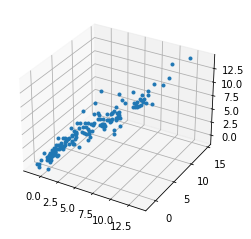

In [26]:
mx, my, mz = [], [], []
for var in infl_period:
    for i in range(len(var)-2):
        mx.append(var[i])
        my.append(var[i+1])
        mz.append(var[i+2])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(mx, my, mz, '.')
plt.show()

1- Introdução: objetivo da análise
2- Dados: Fontes dos dados
3- Abordagem, métodos e algorítmos:
    3.1- Interpretação dos dados
    3.2- Estatísticas utilizadas
    3.4- Métodos não lineares:
        3.4.1- Regressão polinomial
        3.4.2- Machine Learn (multi-layer perceptron)
    3.5- Ferramentas (python, scipy e scikit-learn)
4- Análse geral:
    4.1- Inflação no Brasil:
        4.1.1- Historia da inflação no brasil
        4.1.2- Relação entre o dólar e a economia brasileira
        4.1.3- Relação entre o petróleo e a economia brasileira
    4.2- Correlação entre variáveis
    4.3- Análise das inflações pelo mundo a partir de 2000
5- Modelagem:
    5.1- Métodos lineares
    5.2- Métodos polinomiais
    5.3- Métodos de machine learn
6- Conclusão: através dos modelos inferir sobre o futuro economico no pais